In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

## Import Dataset from Google Drive
---



In [64]:
from google.colab import drive


In [65]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [66]:
#Path to the main directory
folder_path = '/content/gdrive/My Drive/Fact vs Opinion/'

In [67]:
trainpath_fact = folder_path + "movies_metadata.csv"
trainpath_opinion = folder_path + "IMDB Dataset.csv"

In [68]:
fact_data = pd.read_csv(trainpath_fact)
fact_data = fact_data.overview
fact_data.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(45466,)

In [69]:
opinion_data = pd.read_csv(trainpath_opinion)
print(opinion_data.shape)

(50000, 2)


In [70]:
print(fact_data[0]) #check fact data sentence 0
print(opinion_data.review[0]) #check opinion data sentence 0

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and 

## Convert Data from Lines into Sentences

In [71]:
def get_sentence(data):
  """
  Here, the input is multiple sentences divided into lines
  The output is a list of lists of a sentence each
  """
  new_data = []
  for i in range(0,len(data)):
    if type(data[i]) is not str:
      continue
    split_sentence = data[i].split(". ") #this splits each line into the sentences
    for p in split_sentence: #this adds each sentence to new data
      new_data.append(p)
    new_data.append(data[i].split("."))
  return new_data

In [72]:
new_fact_data = get_sentence(fact_data)
print(fact_data[0])
print(new_fact_data[0]) #check that teach line of the data is split into sentences for fact data

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene


In [73]:
new_opinion_data = get_sentence(opinion_data.review)
print(opinion_data.review[0]) #check that each line...
print(new_opinion_data[0]) # ...is converted to a sentence

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [74]:
fact_lg = len(new_fact_data) #amount of number of sentences for facts
opinion_lg = len(new_opinion_data) #amount of number of sentences for opinions

Count of facts:  45466 
Count of opinions: 50000


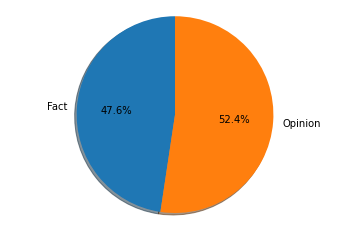

In [75]:
# Pie chart to show the amount of lines each dataset has
labels = 'Fact', 'Opinion'
sizes = [fact_data.shape[0], opinion_data.shape[0]]
print("Count of facts: ", sizes[0], "\nCount of opinions:", sizes[1])

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Count of facts:  164896 
Count of opinions: 541161


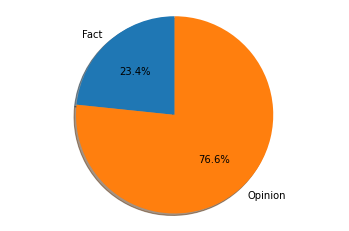

In [76]:
# Pie chart to show how many sentences each dataset has
labels = 'Fact', 'Opinion'
sizes = [fact_lg, opinion_lg]
print("Count of facts: ", sizes[0], "\nCount of opinions:", sizes[1])

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Punctuation Frequency

In [77]:
def count_punctuation(data, ratio): 
  """
  The frequency of each of the punctuation types will be counted for a given dataset, normalised by the ratio compared to the other dataset for fair comparisons
  """
  punctuation = "!?.',()_"
  punctuation_dictionary = {"!":0, "?":0, ".": 0, "'": 0, ",": 0, "(" : 0, ")": 0, "_": 0}

  for i in range(0, len(data)):
    sentence = data[i]
    if type(sentence) is not str:
      continue
    for let in sentence:
      if let in punctuation:
        punctuation_dictionary[let] += 1

  for each in punctuation_dictionary:
    punctuation_dictionary[each] = punctuation_dictionary[each]*ratio #multiply by the ratio to normalise

  return punctuation_dictionary

{'!': 1546, '?': 2765, '.': 49119, "'": 31173, ',': 133694, '(': 10036, ')': 10060, '_': 19}


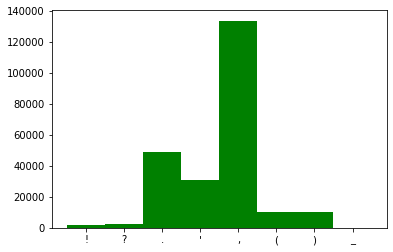

In [78]:
#The punctuation of the facts' dataset is counted and plotted
fact_punctuation_dictionary = count_punctuation(new_fact_data, 1)
p2 = plt.bar(fact_punctuation_dictionary.keys(), fact_punctuation_dictionary.values(), 1, color='g')
print(fact_punctuation_dictionary)

{'!': 14980.65630006597, '?': 9853.642165640169, '.': 63793.32890581546, "'": 80369.74016974616, ',': 166010.31657491947, '(': 21203.095123262763, ')': 21715.918419841786, '_': 303.79371758127434}


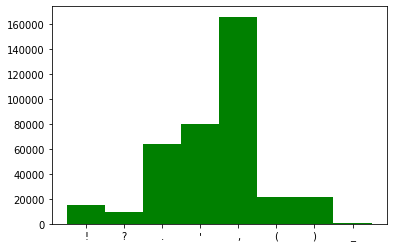

In [79]:
#The punctuation for the opinions' dataset is counted and plotted
opinion_punctuation_dictionary = count_punctuation(new_opinion_data, fact_lg/opinion_lg)
plt.bar(opinion_punctuation_dictionary.keys(), opinion_punctuation_dictionary.values(), 1, color='g')
print(opinion_punctuation_dictionary)

## Tokenisation and Word Count in Sentence

In [80]:
import re

def preprocessSentences(labels):
  #this tokenises each of the sentences, adds sentence start and ends
  data = []
  for line in labels: #Split sentences based on punctuation
    sentence = []
    #Add begin sentence tag
    sentence.append('<s>')
    if type(line) is not str:
      continue
    for word in line.split(): 
      word = word.lower()
      word = re.sub(r'[^\w\s]', '', word)
      sentence.append(word)
    sentence.append('</s>')
    data.append(sentence)
  return data

In [81]:
tokenised_fact = preprocessSentences(new_fact_data) #tokenisation of facts' dataset

In [82]:
tokenised_opinion = preprocessSentences(new_opinion_data) #tokenisation of opinions' dataset
print(tokenised_opinion[0]) #example of what was stated above

['<s>', 'one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', 'youll', 'be', 'hooked', '</s>']


In [83]:
def count_words(data):
  #this function will check how many words are in each sentence and get the average
  divisor = len(data)
  count_data = []
  count = 0
  for i in range(0, len(data)):
    num_words_in_sentence = len(data[i])
    count += num_words_in_sentence
    count_data.append(num_words_in_sentence)
  average = count/divisor
  return average, count_data

In [84]:
fact_average, fact_sentence_count = count_words(tokenised_fact) 
print(fact_average) #average word in each fact sentence

22.37602173046252


In [85]:
opinion_average, opinion_sentence_count = count_words(tokenised_opinion)
print(opinion_average) #average word in each opinion sentence

25.526475025500805


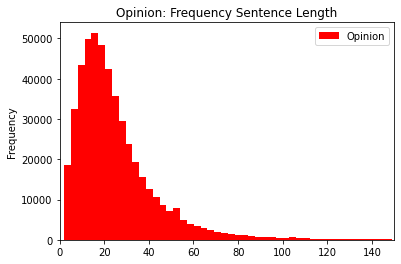

In [86]:
# Histogram of Sentence Length Frequency for Opinions
plt.hist(opinion_sentence_count, bins = 300, color = 'r', label = 'Opinion')
plt.gca().set(title='Opinion: Frequency Sentence Length', ylabel='Frequency')
plt.xlim(0,150)
plt.legend();

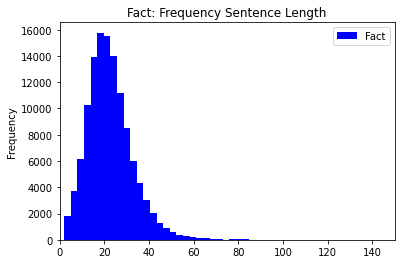

In [87]:
# Histogram of Sentence Length Frequency for Facts
plt.hist(fact_sentence_count, bins = 50, color = 'b', label = 'Fact')
plt.gca().set(title='Fact: Frequency Sentence Length', ylabel='Frequency')
plt.xlim(0,150)
plt.legend();

## Key Word Search

In [88]:
def find_words(opinion_data, fact_data, words):
  #this function will get the opinion and fact dataset, and count the words dataset that are in each and then normalise
  opinion_lg = len(opinion_data)
  fact_lg = len(fact_data)
  ratio_opinion = fact_lg/opinion_lg
  word_count_fact = []
  word_count_opinion = []
  for each in words:
    count_fact = 0
    count_opinion = 0
    for opinion_sentence in opinion_data:
      for opinion_word in opinion_sentence:
        if opinion_word == each:
          count_opinion += 1
    for fact_sentence in fact_data:
      for fact_word in fact_sentence:
        if fact_word == each:
          #print(fact_word, each)
          count_fact += 1

    word_count_fact.append(count_fact)
    word_count_opinion.append(count_opinion*ratio_opinion)

  return word_count_opinion, word_count_fact

In [89]:
# The frequency of the key words (pronouns) outlined below are counted and normalised for both datasets
print(find_words(tokenised_opinion, tokenised_fact, ["i", "me", "you", "he", "she", "it", "him", "her", "it", "we", "us", "they", "them"]))

([37277.64000806253, 5089.765156435466, 14598.20922263779, 12731.030615215785, 5853.989742670937, 37476.17173187611, 4149.067926810149, 8393.480101229536, 37476.17173187611, 4683.14277395803, 1877.4728449530805, 10179.77541376453, 3758.132001522922], [465, 107, 976, 20501, 9692, 7246, 8359, 21522, 7246, 891, 1175, 10140, 4465])


In [90]:
fact_lg/opinion_lg

0.3047078411045881

In [91]:
print(find_words(tokenised_opinion, tokenised_fact, ["a", "the"]))

([78559.73841571297, 162707.04190275693], [99055, 138472])


## Word Embedding: Bag of Words, tf-idf Prep

In [92]:
def bag_of_words_prep(data):
  #this function removes the list of list and only has a list of tokens prepared for bag of words
  new_data = []
  for each in data:
    for word in each: 
      new_data.append(word)
  return new_data

In [93]:
def bag_of_words_preprocess(data1, data2, N, mid, end):
  #input list of list of tokens converted to list of string sentences
  train_data = []
  test_data = []
  train_y = []
  test_y = []
  for p in range(0, mid):
    sen = ""
    for word in data1[p]:
      sen = sen + " " + word
    train_data.append(sen)
    train_y.append(0)
  for i in range(0, mid):
    sen = ""
    for word in data2[i]:
      sen = sen + " " + word
    train_data.append(sen)
    train_y.append(1)
  for q in range(mid, end):
    sen = ""
    for word in data1[q]:
      sen = sen + " " + word
    test_data.append(sen)
    test_y.append(0)
  for l in range(mid, end):
    sen = ""
    for word in data2[l]:
      sen = sen + " " + word
    test_data.append(sen)
    test_y.append(1)
  return train_data, train_y, test_data, test_y

## Model: Logistic Regression, Naive Bayes

In [129]:
#Split of the data to use
N = 120384
X_train, y_train, X_test, y_test = bag_of_words_preprocess(tokenised_fact, tokenised_opinion, N, 79000, 120384) 
print(len(X_train), len(y_train), len(X_test), len(y_test))

158000 158000 82768 82768


In [130]:
X_train[0]

' <s> led by woody andys toys live happily in his room until andys birthday brings buzz lightyear onto the scene </s>'

In [131]:
y_train[0]

0

In [132]:
#tdidf for Logistic

vectorizer = TfidfVectorizer() #created an instance of the word embedding

Xtrain_tfidf = vectorizer.fit_transform(X_train)
Xtest_tfidf = vectorizer.transform(X_test)

print("Logistic Regression")

#logistic regression for tdidf
logreg = LogisticRegression()
logreg.fit(Xtrain_tfidf, y_train)

print("Accuracy using tfidf for training data:", logreg.score(Xtrain_tfidf, y_train)) 
print("Accuracy using tfidf for testing data:",logreg.score(Xtest_tfidf, y_test))

pred_logreg = logreg.predict(Xtest_tfidf)
confusion = confusion_matrix(y_test, pred_logreg)
print(confusion, "\n")

Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy using tfidf for training data: 0.911367088607595
Accuracy using tfidf for testing data: 0.8776217861975643
[[37186  4198]
 [ 5931 35453]] 



In [ ]:

#multinomial naive bayes for ididf

print("Multinomial Naive Bayes")
nb = MultinomialNB()
nb.fit(Xtrain_tfidf, y_train)

print(nb.score(Xtrain_tfidf, y_train))
print(nb.score(Xtest_tfidf, y_test))

pred_nb = nb.predict(Xtest_tfidf)
confusion = confusion_matrix(y_test, pred_nb)
print(confusion)

In [96]:
#Bag of Words Logistic and Naive Bayes

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer() #initialise
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

#logistic regression 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

pred_logreg = logreg.predict(X_test)
confusion = confusion_matrix(y_test, pred_logreg)
print(confusion)

#multinomial naive bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

print(nb.score(X_train, y_train))
print(nb.score(X_test, y_test))

pred_nb = nb.predict(X_test)
confusion = confusion_matrix(y_test, pred_nb)
print(confusion)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.9301708860759493
0.8716412139957471
[[36306  5078]
 [ 5546 35838]]
0.9015253164556962
0.8693456408273729
[[35646  5738]
 [ 5076 36308]]


## Random Tree Classifier Model

In [97]:
#Due to the higher runtime, a smaller training and testing set has to be created
N = 120384
X_train, y_train, X_test, y_test = bag_of_words_preprocess(tokenised_fact, tokenised_opinion, N, 20000, 25000) 
print(len(X_train), len(y_train), len(X_test), len(y_test))

40000 40000 10000 10000


In [98]:
#tdif word embedding

vectorizer = TfidfVectorizer()
Xtrain_tfidf = vectorizer.fit_transform(X_train)
Xtest_tfidf = vectorizer.transform(X_test)

In [99]:
#Bag of Words word embedding

vect = CountVectorizer() #initialise
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [100]:
#random forest classifier 
k = 40000
rf = RandomForestClassifier()
rf.fit(X_train[:k], y_train[:k])

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
pred_rf = rf.predict(X_test)
print(confusion_matrix(y_test, pred_rf))

rfIDF = RandomForestClassifier()
rfIDF.fit(Xtrain_tfidf[:k], y_train[:k])

print(rfIDF.score(Xtrain_tfidf, y_train))
print(rfIDF.score(Xtest_tfidf, y_test))
pred_rfIDF = rfIDF.predict(X_test)
print(confusion_matrix(y_test, pred_rfIDF))

0.99915
0.8633
[[4281  719]
 [ 648 4352]]
0.99915
0.8701
[[3566 1434]
 [ 400 4600]]


## SVM Model

In [101]:
#Due to the higher running time, a lower training and testing set have to be created
N = 120384
X_train, y_train, X_test, y_test = bag_of_words_preprocess(tokenised_fact, tokenised_opinion, N, 10000, 15500) 
#fact is 0, opinion is 1 in that order
print(len(X_train), len(y_train), len(X_test), len(y_test))

20000 20000 11000 11000


In [102]:
#tdif embedding

vectorizer = TfidfVectorizer()
Xtrain_tfidf = vectorizer.fit_transform(X_train)
Xtest_tfidf = vectorizer.transform(X_test)

In [103]:
#Bag of Words embedding

vect = CountVectorizer() #initialise
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [104]:
# rgf kernel hyperparameter for SVC() is tested here
k = 20000
classifier = SVC()
classifier.fit(X_train,y_train)

print(classifier.score(X_train[:k], y_train[:k]))
print(classifier.score(X_test, y_test))
pred_cla = classifier.predict(X_test)
print(confusion_matrix(y_test, pred_cla))

classifierIDF = SVC(kernel='rbf', random_state = 1)
classifierIDF.fit(Xtrain_tfidf[:k], y_train[:k])

print(classifierIDF.score(Xtrain_tfidf, y_train))
print(classifierIDF.score(Xtest_tfidf, y_test))
pred_claIDF = classifierIDF.predict(X_test)
print(confusion_matrix(y_test, pred_claIDF))


0.946
0.8716363636363637
[[4922  578]
 [ 834 4666]]
0.9846
0.881
[[5474   26]
 [5381  119]]


In [105]:
# poly kernel as a hyperparameter is tested here
k = 20000
classifier = SVC(kernel = 'poly')
classifier.fit(X_train,y_train)

print(classifier.score(X_train[:k], y_train[:k]))
print(classifier.score(X_test, y_test))
pred_cla = classifier.predict(X_test)
print(confusion_matrix(y_test, pred_cla))

classifierIDF = SVC(kernel = 'poly')
classifierIDF.fit(Xtrain_tfidf[:k], y_train[:k])

print(classifierIDF.score(Xtrain_tfidf, y_train))
print(classifierIDF.score(Xtest_tfidf, y_test))
pred_claIDF = classifierIDF.predict(X_test)
print(confusion_matrix(y_test, pred_claIDF))

0.8398
0.741909090909091
[[5268  232]
 [2607 2893]]
0.99745
0.8416363636363636
[[3283 2217]
 [ 460 5040]]
